# AlloBench Dataset Creation Pipeline

TODO: Fix Active Site annotation with respect to PDB and not Uniprot

Merge on PDB ID and Uniprot ID to fix obsolete UniProt IDs

Add Protein Name Organism from PDB and UniProt

Check PDB files not available as .pdb and download mmCIF and convert to PDB if missing residues model and save structure

In [1]:
import os, sys

# Add ../scripts directory to python path
module_path = os.path.abspath('../scripts')
if module_path not in sys.path:
    sys.path.append(module_path)

# Import local modules from ../scripts directory
import pdb_utils
import parse_asd_xml

## Get AlloSteric Database (ASD) Data

ASD provides the allosteric site information in a tab delimited file (ASD_Release_202309_AS.txt) or as XML files (ASD_Release_202306_XF.tar.gz). However, 1620 entries of 3102 in ASD_Release_202309_AS.txt are missing the allosteric site residues. Refer the `Issues with ASD Tab Delimited File.ipynb` for details. Hence, the data is parsed from the XML files instead.

Download the ASD_Release_202306_XF.tar.gz from https://mdl.shsmu.edu.cn/ASD/module/download/download.jsp?tabIndex=1 and extract it to the ../data directory or provide the path to the extracted directory to parse_asd_xml()

In [2]:
df_asd = parse_asd_xml.parse_asd_xml('../data/ASD_Release_202306_XF/')

# Make the UniProt and PDB IDs uppercase to facilitate merging on these later
df_asd['allosteric_pdb'] = df_asd['allosteric_pdb'].str.upper()
df_asd['pdb_uniprot'] = df_asd['pdb_uniprot'].str.upper()

print('Number of Rows:             ', df_asd.shape[0])
print('Number of Unique PDB IDs:   ', df_asd['allosteric_pdb'].nunique())
print('Number of Unique UniProt AC:', df_asd['pdb_uniprot'].nunique())

100%|██████████| 2419/2419 [00:03<00:00, 612.69it/s]

Number of Rows:              3172
Number of Unique PDB IDs:    2993
Number of Unique UniProt AC: 701


## Fix Obsolete PDB Entries

Some PDB IDs in the allosteric_pdb column are obsolete. The list of obsolete PDB IDs is downloaded from the Protein Data Bank. The obsolete PDB IDs are replaced by the superseded PDB IDs and structures without any superseded PDB IDs are removed.

In [3]:
import requests
import json
import gzip

response = requests.get('https://files.wwpdb.org/pub/pdb/holdings/all_removed_entries.json.gz')

obsolete_pdb = {}
for pdb_id, value in json.loads(gzip.decompress(response.content)).items():
    if 'superseded_by' in value:
        # Select the last element in the list of superseded PDB IDs
        obsolete_pdb[pdb_id] = value['superseded_by'] # [-1] 
    else:
        obsolete_pdb[pdb_id] = []

In [4]:
import pandas as pd

df_obsolete_pdb = pd.DataFrame.from_dict(obsolete_pdb, orient='index')
df_obsolete_pdb.index.name = 'Obsolete PDB ID'

# Obsolete PDB IDs in ASD
df_obsolete_pdb_asd = df_obsolete_pdb[df_obsolete_pdb.index.isin(df_asd['allosteric_pdb'])]

# Replace the obsolete PDB IDs
df_asd['allosteric_pdb'] = df_asd['allosteric_pdb'].replace(df_obsolete_pdb_asd.to_dict()[0])

# Check if any of the obsolete PDB IDs had more than one updated PDB IDs
df_obsolete_pdb_asd

,0,1,2
Obsolete PDB ID,,,
1HWZ,6DHD,None,None
3MVQ,6DHL,None,None
3MW9,6DHM,None,None
3QMU,6DHQ,None,None
4GAR,4V9C,None,None
4GAU,4V9C,None,None
4LEG,5J94,None,None


While most obsolete PDB IDs are superseded by only one PDB ID, there exists obsolete PDB IDs superseded by multiple PDB IDs. However, the ASD does not contain such structures.

In [5]:
print('Number of Rows:             ', df_asd.shape[0])
print('Number of Unique PDB IDs:   ', df_asd['allosteric_pdb'].nunique())
print('Number of Unique UniProt AC:', df_asd['pdb_uniprot'].nunique())

Number of Rows:              3172
Number of Unique PDB IDs:    2991
Number of Unique UniProt AC: 701


## Fix Obsolete UniProt Entries

The active site information will be obtained from the UniProt database hence it is critical to have the correct UniProt ID for the ASD protein structures. The code to fix the obsolete UniProt IDs is in the fix_uniprot_id.py

1. Get the list of UniProt IDs in the structure corresponding to each PDB ID in the ASD from the PDB using GraphQL  
2. If the UniProt ID from ASD is present in the UniProt IDs fetched from the PDB then the UniProt ID from ASD is correct and does not need any modification.  
3. If the UniProt ID from ASD is absent in the UniProt IDs fetched from the PDB then,  
    a. If only 1 UniProt ID was obtained then that ID may be assgined without ambiguity  
    b. If 0 or multiple UniProt IDs were obtained then these must be reviewed and any suitable UniProt IDs are included in the  

In [6]:
import pdb_utils

# Rename the columns to pdb_id and uniprot_id before passing the dataframe to uniprot_pdb_fix() function.
df_asd_pdb_uniprot = df_asd[['allosteric_pdb', 'pdb_uniprot']].rename(
    columns={'allosteric_pdb': 'pdb_id', 'pdb_uniprot': 'uniprot_id'}
).drop_duplicates()

df_asd_pdb_uniprot = pdb_utils.uniprot_pdb_fix(df_asd_pdb_uniprot)

PDB IDs Absent from ASD with Zero or Multiple UniProt ID fetched from the PDB


,pdb_id,uniprot_id,uniprot_id_from_pdb
846,1CKK,P62158,"{P0DP33, P97756}"
844,1IQ5,P62158,"{P0DP33, Q3Y416}"
843,1NWD,P62158,"{Q07346, P0DP33}"
845,3J41,P62158,"{Q6J8I9, P0DP23}"
2736,3OBK,S8F7E9,{}
2473,3OWI,,{}
2479,3OWW,,{}
2470,3OWZ,,{}
2482,3OXE,,{}
2478,3OXJ,,{}


The following PDB IDs from ASD were dropped: 3OWZ, 3OXM, 3OWI, 3Q3Z, 3OXJ, 3OWW, 3OXE because these are structures of glycine riboswitch, an RNA element and do not have an associated UniProt IDs.

In [7]:
# Reinsert PDB ID and UniProt AC combination from the manual curation of the table above
df_manual_curation = pd.DataFrame([
    ['1CKK', 'P0DP33'], ['1IQ5', 'P0DP33'], ['1NWD', 'P0DP33'],
    ['3J41', 'P0DP23'], ['3OBK', 'S8F7E9'], ['3RHW', 'G5EBR3'],
    ['3RI5', 'G5EBR3'], ['3RIA', 'G5EBR3'], ['3RIF', 'G5EBR3'],
    ['4A2U', 'P9WP65'], ['4P86', 'P39765'], ['6KDY', 'O43837'],
    ['6UI4', 'I1RCT2'], ['7LD3', 'P30542'], ['7O83', 'P01116']],
    columns=['pdb_id', 'uniprot_id'])

df_asd_pdb_uniprot = pd.concat([df_asd_pdb_uniprot, df_manual_curation])

df_asd_updated =  df_asd.drop(columns='pdb_uniprot').merge(
    df_asd_pdb_uniprot.drop_duplicates().rename(
        columns={'pdb_id': 'allosteric_pdb', 'uniprot_id': 'pdb_uniprot'}),
    how='left',
    on='allosteric_pdb'
)

asd_csv_output = "../output/ASD_Updated.csv"

df_asd_updated[['target_id', 'target_gene', 'organism', 'pdb_uniprot', 'allosteric_pdb',
       'modulator_serial', 'modulator_alias', 'modulator_chain',
       'modulator_class', 'modulator_feature', 'modulator_name',
       'modulator_resi', 'function', 'position', 'pubmed_id', 'ref_title',
       'site_overlap', 'allosteric_site_residue'
               ]].to_csv(asd_csv_output, index=False)

print('Number of Rows:             ', df_asd_updated.shape[0])
print('Number of Unique PDB IDs:   ', df_asd_updated['allosteric_pdb'].nunique())
print('Number of Unique UniProt AC:', df_asd_updated['pdb_uniprot'].nunique())

Number of Rows:              3184
Number of Unique PDB IDs:    2991
Number of Unique UniProt AC: 690


## Merge with Additional Information from the PDB

Obtain the data from PDB using its GraphQL API. Mapping between PDB chain ids and UniProt IDs. The oligomeric state, and stoichiometry of the proteins.

In [8]:
def get_chain_uniprot(array):
    output = set()
    if isinstance(array, str):
        array = eval(array)
    for chain in array:
        for uniprot_id in chain[1]:
            output.add(uniprot_id)
    return sorted(output)


df_pdb = pdb_utils.get_pdb_data(df_asd_updated['allosteric_pdb'].unique())

df_pdb['uniprot_in_pdb'] = df_pdb['chain_uniprot_mapping'].apply(get_chain_uniprot)

df_pdb.rename(columns={'pdb_id': 'allosteric_pdb'}, inplace=True)
df_asd_pdb_merged = df_asd_updated.merge(df_pdb)

print('Number of Rows:             ', df_asd_pdb_merged.shape[0])
print('Number of Unique PDB IDs:   ', df_asd_pdb_merged['allosteric_pdb'].nunique())
print('Number of Unique UniProt AC:', df_asd_pdb_merged['pdb_uniprot'].nunique())

Number of Rows:              3184
Number of Unique PDB IDs:    2991
Number of Unique UniProt AC: 690


## Download PDB files

The large structures with PDB IDs 4V9C, 3BCR, 8DD3, 7AIA, 6VVH, 7APH, 7OFU are not available in .pdb format.

However, these are available in PDBx/mmCIF format

In [ ]:
pdb_utils.download_structures(
    pdb_ids=df_asd_pdb_merged['allosteric_pdb'].unique(),
    download_dir='../data/pdb_downloaded/'
)

## Find PDB structures with missing Residues

In [ ]:
import glob
from tqdm.contrib.concurrent import process_map

import fix_missing_residues

pdb_structures = sorted(glob.glob('../data/pdb_downloaded/*.pdb') +
                        glob.glob('../data/pdb_downloaded/*.cif'))

def check_pdb(structure):
    pdb_id = os.path.splitext(os.path.basename(structure))[0]
    missing_residues = fix_missing_residues.check_missing_residues(structure)
    return pdb_id, *missing_residues


pdb_missing_residues = process_map(check_pdb, pdb_structures, chunksize=1)

df_missing_residues = pd.DataFrame(pdb_missing_residues, columns=['PDB ID', 'Has Missing Residues', 'Missing Residues'])
df_missing_residues.value_counts('Has Missing Residues')

## Find PDB Structures with Multiple Models

In [ ]:
def count_models_and_chains(pdb_file):
    pdb_id = os.path.splitext(os.path.basename(pdb_file))[0]
    structure = fix_missing_residues.parse_structure(pdb_file)
    # for chain in structure.get_chains():
    num_chains = len(list(structure.get_chains()))
    num_models = len(list(structure.get_models()))
    return pdb_id, num_models, num_chains

model_chain_count = process_map(count_models_and_chains, pdb_structures, chunksize=1)
df_num_models_chains = pd.DataFrame(model_chain_count, columns=['PDB ID', 'Number of Models', 'Number of Chains'])

In [ ]:
df_num_models_chains.value_counts(['Number of Chains']).sort_index()

In [ ]:
df_num_models[df_num_models['Number of Chains'] > 25]

## Get Catalytic Site Atlas Data

1. Get the manually curated catalytic residues from the Mechanism and Catalytic Site Atlas (M-CSA)
2. Parse the JSON file and create a pandas dataframe

In [9]:
response = requests.get('https://www.ebi.ac.uk/thornton-srv/m-csa/api/residues/?format=json')
mcsa_data = response.json()

output = []
for i, entry in enumerate(mcsa_data):
    if entry['residue_chains']:
        chain_name          = entry['residue_chains'][0]['chain_name']
        pdb_id              = entry['residue_chains'][0]['pdb_id'].upper()
        assembly_chain_name = entry['residue_chains'][0]['assembly_chain_name']
        assembly            = entry['residue_chains'][0]['assembly']
        code                = entry['residue_chains'][0]['code']
        resid               = entry['residue_chains'][0]['resid']
    else:
        chain_name          = ''
        pdb_id              = ''
        assembly_chain_name = ''
        assembly            = ''
        code                = ''
        resid               = float('nan')
    uniprot_id          = entry['residue_sequences'][0]['uniprot_id']
    res_seq_code        = entry['residue_sequences'][0]['code']
    res_seq_resid       = entry['residue_sequences'][0]['resid']

    output.append([chain_name, pdb_id, assembly_chain_name, assembly,
                   code, resid, uniprot_id, res_seq_code, res_seq_resid])

df_csa = pd.DataFrame(output, columns=['chain_name', 'pdb_id',
                                       'assembly_chain_name', 'assembly',
                                       'code', 'resid', 'uniprot_id',
                                       'res_seq_code', 'res_seq_resid'])

In [10]:
# Make the UniProt and PDB IDs uppercase to facilitate merging on these later
df_csa['uniprot_id'] = df_csa['uniprot_id'].str.upper()
df_csa['pdb_id'] = df_csa['pdb_id'].str.upper()

# Replace the assembly_chain_name with chain_name if there are odd chain_name in assembly_chain_name column
df_csa.loc[df_csa['assembly_chain_name'].str.len() > 1, 'assembly_chain_name'] = df_csa['chain_name']
print('Number of UniProt IDs in M-CSA:', df_csa['uniprot_id'].nunique())

Number of UniProt IDs in M-CSA: 989


In [11]:
print('Number of Rows:             ', df_csa.shape[0])
print('Number of Unique PDB IDs:   ', df_csa['pdb_id'].nunique())
print('Number of Unique UniProt AC:', df_csa['uniprot_id'].nunique())

Number of Rows:              5248
Number of Unique PDB IDs:    1003
Number of Unique UniProt AC: 989


3. Download M-CSA PDB IDs

In [12]:
def uniprot_from_pdb_chains(pdb_chains):
    pdb_chains_string = '", "'.join(pdb_chains)
    
    body = 'query {polymer_entity_instances(instance_ids: ["' + pdb_chains_string + '"])' + """
      {
        rcsb_id
        polymer_entity {
          uniprots {
            rcsb_id
          }
        }
      }
    }
    """
    response = requests.post(url='https://data.rcsb.org/graphql', json={"query": body})
    response_data = response.json()

    id_mapping = []
    for record in response_data['data']['polymer_entity_instances']:
        rcsb_id, chain = record['rcsb_id'].split('.')
        if record['polymer_entity']['uniprots'] is not None:
            uniprot_id = record['polymer_entity']['uniprots'][0]['rcsb_id']
        else:
            uniprot_id = ''
        id_mapping.append([rcsb_id, chain, uniprot_id])
        
    return pd.DataFrame(id_mapping, columns=['pdb_id', 'chain', 'uniprot_id'])

### Update obsolete UniProt IDs

In [13]:
csa_pdb_chains = set(df_csa['pdb_id'] + '.' + df_csa['assembly_chain_name'])
df_csa_pdb = uniprot_from_pdb_chains(csa_pdb_chains)
df_csa_pdb = df_csa_pdb.rename(columns={'chain': 'assembly_chain_name', 'uniprot_id': 'UniProt_AC'})
df_csa_merged = df_csa.merge(df_csa_pdb, how='left', on=['pdb_id', 'assembly_chain_name'])
df_csa_merged.loc[(df_csa_merged['uniprot_id'] != df_csa_merged['UniProt_AC']) & ~df_csa_merged['UniProt_AC'].isna(), 'uniprot_id'] = df_csa_merged['UniProt_AC']

### Mismatched UniProt IDs

In [14]:
df_csa_merged_subset = df_csa_merged[['chain_name', 'pdb_id', 'assembly_chain_name', 'uniprot_id', 'UniProt_AC']].drop_duplicates()
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    display(
        df_csa_merged_subset[df_csa_merged_subset['uniprot_id'] != df_csa_merged_subset['UniProt_AC']]
    )

,chain_name,pdb_id,assembly_chain_name,uniprot_id,UniProt_AC
1698,,,,P00392,NaN
1710,,,,P17854,NaN
1731,,,,P00903,NaN
1971,,,,Q56310,NaN
2183,,,,Q712I6,NaN
2960,,,,P28332,NaN
2981,,,,A9CG74,NaN
3860,,,,Q57764,NaN
4061,,,,,NaN
4073,,,,P0AES7,NaN


In [15]:
df_csa_pdb_uniprot = df_csa_merged_subset[['pdb_id', 'uniprot_id']].drop_duplicates()
print('Number of Rows:             ', df_csa_pdb_uniprot.shape[0])
print('Number of Unique PDB IDs:   ', df_csa_pdb_uniprot['pdb_id'].nunique())
print('Number of Unique UniProt AC:', df_csa_pdb_uniprot['uniprot_id'].nunique())

Number of Rows:              1045
Number of Unique PDB IDs:    1003
Number of Unique UniProt AC: 1037


3. Filter the M-CSA data for proteins contained in the ASD

In [16]:
df_csa_in_asd = df_csa_merged[df_csa_merged['UniProt_AC'].isin(df_asd_updated['pdb_uniprot'])].copy()

4. Group by PDB ID and UniProt ID

In [17]:
df_csa_in_asd['catalytic_site'] = (df_csa_in_asd['assembly_chain_name'] + '-'
                                   + df_csa_in_asd['res_seq_resid'].astype(str)
                                   + '-' + df_csa_in_asd['res_seq_code']
                                   )

df_csa_in_asd['catalytic_site_resids'] = (
    df_csa_in_asd['res_seq_resid'])

df_csa_in_asd_grouped = df_csa_in_asd[
    ['UniProt_AC', 'catalytic_site', 'catalytic_site_resids']
].groupby(['UniProt_AC']).agg(set).reset_index()

In [18]:
df_csa_in_asd_grouped

,UniProt_AC,catalytic_site,catalytic_site_resids
0,O75164,"{A-288-Ser, A-276-His, A-188-His, A-190-Glu, A...","{288, 170, 177, 276, 188, 190}"
1,P00183,"{A-253-Thr, A-358-Cys, A-359-Leu, A-360-Gly, A...","{358, 359, 360, 187, 252, 253}"
2,P00452,"{A-439-Cys, A-462-Cys, A-731-Tyr, A-437-Asn, A...","{225, 462, 437, 439, 441, 730, 731}"
3,P00489,"{A-570-Arg, A-575-Lys, A-569-Lys, A-681-Lys, A...","{677, 681, 570, 569, 378, 575}"
4,P00636,"{A-122-Asp, A-99-Glu, A-281-Glu, A-98-Glu, A-1...","{121, 98, 99, 69, 75, 119, 281, 122}"
5,P00720,"{A-11-Glu, A-20-Asp}","{11, 20}"
6,P00864,"{A-506-Glu, A-396-Arg, A-581-Arg, A-138-His, A...","{581, 713, 138, 396, 506, 543}"
7,P00929,"{A-235-Ser, A-60-Asp, A-233-Ser, A-175-Tyr, A-...","{102, 233, 234, 235, 173, 175, 49, 183, 60}"
8,P00953,"{A-111-Lys, A-192-Lys, A-195-Lys}","{192, 195, 111}"
9,P00968,"{C-841-Glu, C-283-Asn, C-843-Asn, C-299-Glu, C...","{129, 841, 202, 843, 299, 301, 715, 303, 848, ..."


In [19]:
print('Number of Unique UniProt AC:', df_csa_in_asd_grouped['UniProt_AC'].nunique())

Number of Unique UniProt AC: 57


## Download the Active and Binding Site Data from UniProt

In [20]:
import itertools
import tqdm
import SPARQLWrapper # import JSON, SPARQLWrapper

import sys

if sys.version_info >= (3, 12):
    from itertools import batched
else:
    try:
        from more_itertools import batched
    except ImportError:
        def batched(iterable, chunk_size):
            iterator = iter(iterable)
            while chunk := tuple(itertools.islice(iterator, chunk_size)):
                yield chunk


def get_uniprot_site_annotations(uniprot_ids):
    # Set the SPARQL endpoint (UniProt)
    sparql = SPARQLWrapper.SPARQLWrapper("https://sparql.uniprot.org/sparql")

    output = []
    for uniprot_subset in tqdm.tqdm(itertools.batched(uniprot_ids, 200)):
        uniprot_string = ' '.join([f'uniprotkb:{id}' for id in uniprot_subset])
                 
        # Define the query
        query_string = f"""
PREFIX up: <http://purl.uniprot.org/core/>
PREFIX uniprotkb: <http://purl.uniprot.org/uniprot/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX faldo: <http://biohackathon.org/resource/faldo#>
SELECT DISTINCT ?uniprot_id ?begin ?end ?site ?comment
WHERE
{{
    VALUES ?protein {{ {uniprot_string} }}
    BIND(substr(str(?protein), strlen(str(uniprotkb:))+1) AS ?uniprot_id)
  
    ?protein up:annotation ?annotation .
  {{ ?annotation a up:Binding_Site_Annotation }} UNION {{ ?annotation a up:Active_Site_Annotation }} .
    ?annotation rdf:type ?type .
    BIND(substr(str(?type), strlen(str(up:))+1) AS ?site)
    ?annotation up:range ?range .
    ?range faldo:begin/faldo:position ?begin .
    ?range faldo:end/faldo:position ?end .
    OPTIONAL
    {{
        ?annotation up:ligand ?ligand .
        ?ligand rdfs:comment ?comment .
    }}
}}
"""
        sparql.setQuery(query_string)
    
        # Set the output format as JSON
        sparql.setReturnFormat(SPARQLWrapper.JSON)
        
        # Run the SPARQL query and convert to the defined format
        data = sparql.query().convert()

        # Store the query result
        for result in data["results"]["bindings"]:
            output.append({key: value['value'] for key, value in result.items()})
    return pd.DataFrame(output, columns=['uniprot_id', 'site', 'begin', 'end', 'comment'])


def get_uniprot_sequence(uniprot_ids):
    # Set the SPARQL endpoint (UniProt)
    sparql = SPARQLWrapper.SPARQLWrapper("https://sparql.uniprot.org/sparql")

    output = []
    for uniprot_subset in tqdm.tqdm(itertools.batched(uniprot_ids, 200)):
        uniprot_string = ' '.join([f'uniprotkb:{id}' for id in uniprot_subset])
                 
        # Define the query
        query_string = f"""
PREFIX up: <http://purl.uniprot.org/core/>
PREFIX uniprotkb: <http://purl.uniprot.org/uniprot/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
SELECT DISTINCT ?uniprot_id ?sequence
WHERE
{{
    VALUES ?protein {{ {uniprot_string} }}
    BIND(substr(str(?protein), strlen(str(uniprotkb:))+1) AS ?uniprot_id)
    ?protein up:sequence ?isoform .
    ?isoform a up:Simple_Sequence ;
    rdf:value ?sequence .
}}
"""
        sparql.setQuery(query_string)
    
        # Set the output format as JSON
        sparql.setReturnFormat(SPARQLWrapper.JSON)
        
        # Run the SPARQL query and convert to the defined format
        data = sparql.query().convert()

        # Store the query result
        for result in data["results"]["bindings"]:
            output.append({key: value['value'] for key, value in result.items()})
    return pd.DataFrame(output, columns=['uniprot_id', 'sequence'])

In [21]:
uniprot_ids = {uniprot_id for uniprot_id_list in df_asd_pdb_merged['uniprot_in_pdb'].drop_duplicates() for uniprot_id in uniprot_id_list}

df_uniprot_site_annotations = get_uniprot_site_annotations(uniprot_ids)
df_uniprot_sequences = get_uniprot_sequence(uniprot_ids)

5it [00:19,  3.99s/it]
5it [00:03,  1.27it/s]


Fix multiple simple sequences returned by UniProt SparQL and use UniProt REST API to fetch the canonical fasta sequence and remove duplicates

In [22]:
print('Number of Unique UniProt AC:', df_uniprot_site_annotations['uniprot_id'].nunique())

Number of Unique UniProt AC: 629


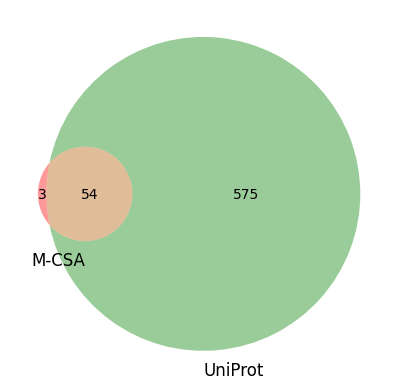

In [27]:
import matplotlib_venn

matplotlib_venn.venn2([set(df_csa_in_asd_grouped['UniProt_AC']),
                       set(df_uniprot_site_annotations['uniprot_id'])],
                      ['M-CSA', 'UniProt']
                     )

In [ ]:
df_duplicated_sequences = df_uniprot_sequences[df_uniprot_sequences.duplicated('uniprot_id', keep=False)]
for uniprot_id in df_duplicated_sequences['uniprot_id'].unique():
    response = requests.get(f'https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta')
    sequence = ''.join(response.text.split('\n')[1:])
    df_uniprot_sequences.loc[df_uniprot_sequences['uniprot_id'] == uniprot_id, 'sequence'] = sequence
df_uniprot_sequences.drop_duplicates(inplace=True)

In [ ]:
df_uniprot_site_annotations.fillna('', inplace=True)
df_uniprot_site_annotations[df_uniprot_site_annotations['comment'].str.contains('alloster')].value_counts('comment')

In [ ]:
# Number of unique UniProt Accesstion Numbers
df_uniprot_site_annotations.loc[df_uniprot_site_annotations['comment'].str.contains('alloster'), 'uniprot_id'].nunique()

In [ ]:
df_uniprot_site_annotations[['comment']] = df_uniprot_site_annotations[['comment']].fillna('')

df_active_site_annotations = df_uniprot_site_annotations[~df_uniprot_site_annotations['comment'].str.contains('alloster')].copy()

df_active_site_annotations['begin'] = df_active_site_annotations['begin'].astype(int)
df_active_site_annotations['end'] = df_active_site_annotations['end'].astype(int)

# Group the annotation of each UniProt ID in multiple rows 
active_sites = []
for index, group in df_active_site_annotations.groupby(['uniprot_id']):
    active_site_residues = []
    for _, record in group.iterrows():
        # Expand the annotation ranges to list of residue indices
        residues = list(range(record['begin'], record['end'] + 1))
        active_site_residues.extend(residues)
    active_sites.append([index[0], active_site_residues])

df_active_sites = pd.DataFrame(active_sites, columns=['uniprot_id', 'active_site_residues'])

df_active_sites = df_uniprot_sequences.merge(df_active_sites, how='left')
df_active_sites[['active_site_residues']] = df_active_sites[['active_site_residues']].fillna('[]')

In [ ]:
df_active_sites

## Combine M-CSA and UniProt

**Note:** Residue indices listed in M-CSA are in agreement with UniProt

In [ ]:
df_active_sites['active_site_residues'] = df_active_sites['active_site_residues'].apply(eval)
df_active_sites.rename(columns={'uniprot_id': 'UniProt_AC'}, inplace=True)

In [ ]:
df_uniprot_csa = df_uniprot.merge(df_csa_in_asd_grouped, how='left', on='UniProt_AC')

active_site_residues = []

for ind, record in df_uniprot_csa.iterrows():
    if record['catalytic_site_resids'] is not float('nan'):
        catalytic_site_resids = record['catalytic_site_resids']
    else:
        catalytic_site_resids = set()
    print(type(record['active_site_residues']), type(catalytic_site_resids))
    active_site_residues.append(sorted(set(record['active_site_residues']) | catalytic_site_resids))

df_uniprot_csa['active_site_residues'] = active_site_residues

# Remove rows with no active site residues
df_uniprot_csa = df_uniprot_csa[(df_uniprot_csa['active_site_residues'].astype(str) != '[]')]

df_uniprot_csa

In [ ]:
df_asd_pdb_merged['uniprot_in_pdb'].apply(len).value_counts()

## Copy the allosteric site annotation to identical chains

In [ ]:
import collections
import itertools

allosteric_sites = []
for index, record in tqdm(df_asd_with_active_site.iterrows(), total=df_asd_with_active_site.shape[0]):
    protein_allosteric_sites = []

    site_residues = []
    for residue in record['allosteric_site_residues']:
        residue = residue.upper()  # Change any lower case residue names or chains to upper case
        chain = residue[0]
        # Convert chains like '1', '2', ... to 'A', 'B', ...
        if chain.isnumeric():
            chain = chr(64 + int(chain))
            residue = chain + residue[1:]  # Update the chain in the residue
        site_residues.append(residue)

    # Create a dictionary with chains with each uniprot id
    uniprot_to_chains = collections.defaultdict(list)
    chains_to_uniprot = collections.defaultdict(list)
    for chain, uniprots, seq in record['chain_uniprot_mapping']:
        for uniprot_id in uniprots:
            uniprot_to_chains[uniprot_id].append(chain)
            chains_to_uniprot[chain].append(uniprot_id)

    for chain, residues in itertools.groupby(site_residues, key=lambda res: res[0]):
        residue_list = list(residues)
        for uniprot in chains_to_uniprot[chain]:
            for identical_chain in uniprot_to_chains[uniprot]:
                protein_allosteric_sites.append([identical_chain, [identical_chain + res[1:] for res in residue_list]])
    allosteric_sites.append(protein_allosteric_sites)

df_asd_with_active_site['allosteric_sites'] = allosteric_sites

## Add active site annotation to identical chains

In [ ]:
active_sites = []
for index, record in tqdm(df_asd_with_active_site.iterrows(), total=df_asd_with_active_site.shape[0]):
    protein_active_sites = []
    for chain in record['chain_uniprot_mapping']:
        for uniprot_id in chain[1]:
            active_site = df_uniprot_csa.loc[df_uniprot_csa['UniProt_AC'] == uniprot_id, 'active_site_residues']
            if not active_site.empty:
                protein_active_sites.append([chain[0], list(active_site)[0]])
    active_sites.append(protein_active_sites)

df_asd_with_active_site['active_sites'] = active_sites

Filter the dataframe with at least one allosteric site reidue and one active or binding site residue

In [ ]:
# Drop the rows with no active site residues
df_asd_with_active_site = df_asd_with_active_site[df_asd_with_active_site['active_sites'].str.len() != 0]

# Drop the rows with no allosteric site residues
df_asd_with_active_site = df_asd_with_active_site[df_asd_with_active_site['allosteric_sites'].str.len() != 0]

In [ ]:
print('Number of Rows:             ', df_asd_with_active_site.shape[0])
print('Number of Unique PDB IDs:   ', df_asd_with_active_site['allosteric_pdb'].nunique())
print('Number of Unique UniProt AC:', df_asd_with_active_site['pdb_uniprot'].nunique())

In [ ]:
df_asd_with_active_site.to_csv('../output/ASD_with_Active_Sites.csv', index=False)